## Train

# 环境准备及数据预处理 
## 导入必要的包和库

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import jieba
import re
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
import warnings

## 读取数据
* 这里，我们首先需要读取.csv文件中的数据，利用pd.read_csv方法读取

In [91]:
raw_dataset = pd.read_csv('../data/preset/minibatch.csv')#读取原始数据

* 我们需要对读取到的数据进行预先清洗，因为从网上爬取的数据会存在空数据
* 所以先要利用dropna方法除去空缺数据，并用reset_index方法重新设置索引

In [92]:
dataset = raw_dataset.dropna(axis=0).reset_index()#清洗数据，去除空数据
val_size = 0.25
idx = list(range(len(dataset)))
random.shuffle(idx)#打乱样本
dataset_train_idx, dataset_val_idx = idx[int(val_size * len(idx)):], idx[:int(val_size * len(idx))]#划分训练集和验证集
dataset_train, dataset_val = dataset.iloc[dataset_train_idx].reset_index(), dataset.iloc[dataset_val_idx].reset_index()#把序号重新标注

* 接着利用random.shuffle方法来打乱样本，并划分训练集和验证集。val_size是验证集所占比例

 **下面展示清洗后得到的验证集**

In [93]:
dataset_val

,level_0,index,movie_id,user_id,rate,time,content
0,17,17,26825482,✔,1.0,2022-03-30 22:50:10,不意外，过气灾难片路数。大概是全人类得新冠之后大脑缩小了一圈。✘/0
1,0,0,26825482,莫挨脑子,1.0,2022-03-25 20:24:25,看到影片开头 华谊兄弟几个字的时候 我就心里有数了……果然…..
2,9,9,26825482,亵渎电影,1.0,2022-03-30 17:04:17,编剧写这种东西，本意是在写一个粗制滥造的网大吧，不仅时时刻刻在侮辱观众的智商，还侮辱了外星智...
3,4,4,26825482,人民南路壹号,2.0,2022-02-13 12:22:24,加上最后一段的灾难特效算它勉强及格吧，在导演本人的作品里应当排在倒数的，很多逻辑漏洞和一言难...


## 清洗数据
* 因为很多影评中含有各种奇怪的标点符号和表情符号，在训练中这一部分我们不需要，所以我们要将这一部分清洗掉
* 下面我们用re.sub正则表达式匹配来进行清洗，并用repalce替换掉字符串中的空格

In [94]:
for i in range(len(dataset_train)):#去除掉所有除汉字外的其他字符，包括空格标点表情符号之类
        dataset_train.loc[i,'content']=re.sub(r"[^\u4e00-\u9fa5 ]+", '', dataset_train['content'][i])
        dataset_train.loc[i,'content']=dataset_train['content'][i].replace(' ','')
for i in range(len(dataset_val)):
        dataset_val.loc[i,'content']=re.sub(r"[^\u4e00-\u9fa5 ]+", '', dataset_val['content'][i])
        dataset_val.loc[i,'content']=dataset_val['content'][i].replace(' ','')

 **下面展示清洗后得到的验证集**

In [95]:
dataset_val

,level_0,index,movie_id,user_id,rate,time,content
0,17,17,26825482,✔,1.0,2022-03-30 22:50:10,不意外过气灾难片路数大概是全人类得新冠之后大脑缩小了一圈
1,0,0,26825482,莫挨脑子,1.0,2022-03-25 20:24:25,看到影片开头华谊兄弟几个字的时候我就心里有数了果然
2,9,9,26825482,亵渎电影,1.0,2022-03-30 17:04:17,编剧写这种东西本意是在写一个粗制滥造的网大吧不仅时时刻刻在侮辱观众的智商还侮辱了外星智慧生命...
3,4,4,26825482,人民南路壹号,2.0,2022-02-13 12:22:24,加上最后一段的灾难特效算它勉强及格吧在导演本人的作品里应当排在倒数的很多逻辑漏洞和一言难尽的...


## 分词
* 到此数据清洗就结束了，接下来我们要将句子进行分词，以便生成对应的词向量
* 首先我们要将训练集和验证集的所有句子全部合起来进行分词，下面是合并的过程

In [7]:
train_content=dataset_train['content']#把所有句子合并在一起方便分词，句与句之间留有空格
train_content=list(train_content)
str=' '
traincontent=str.join(train_content)
val_content=dataset_val['content']
val_content=list(val_content)
str=' '
valcontent=str.join(val_content)

* 注意句子之间要留一个空格以便分词器分词

In [8]:
content=traincontent+' '+valcontent#把训练集和测试集合二为一

* 下面展示合并结果 ，是一个长字符串

In [98]:
content

'看到影片开头华谊兄弟几个字的时候我就心里有数了果然 加上最后一段的灾难特效算它勉强及格吧在导演本人的作品里应当排在倒数的很多逻辑漏洞和一言难尽的地方大概经费都燃烧在了最后分钟没办法再照顾剧情和其他还有一个一看就是被金主华谊塞进去的于文文剧情不需要但是估计经费需要 时间过得真快不敢相信看罗兰艾默里奇上一部已经是两年前的事情了这次罗兰艾默里奇算是三年磨一剑回归灾难片但是全片看下来就觉得很乱没想到年还能看到年时期的同类题材创意不新鲜特效也就一般亿千万美元的预算制作出了亿的效果而且华谊还投资了还有个华谊旗下的中国女演员带资进组戏份还挺多整个就一个无语这片总结就一句话肥宅拯救宇宙 大概是主创团队致力于讲一个自嗨至极的阴谋论导致全片的特效竟然没有服务于剧情和刺激这对于一部灾难片来说就是一场切切实实的灾难相比起人家可是跟各种形式的灾难追逐到最后才不是偷懒地生造一只外星人搞异星灾变那套呢博物馆当然是永远的神啦 这才是在电影院的电影无视定律太过于牛逼减一颗 整个设定太蠢了能把高度文明灭了的在电影里蠢的像个蠢货不管形式和内核都停留在非常陈旧的体系里没有新意 罗兰的正常水平发挥吧拍了那么多年灾难片了题材在改变但是套路却基本一致这部倒算是大咖云集如果想去电影院看看牛的技术可以一看 一定要看一定要看一定要看画面和特效远超预期他的最后视觉大高潮我整个喊了有十遍卧槽吧期待更多的科学学说和未被证实的理论搬上银幕最后骂的人奥斯卡颁奖了马上在家看看资源不好吗 不意外过气灾难片路数大概是全人类得新冠之后大脑缩小了一圈 什么鬼烂的一塌糊涂 编剧写这种东西本意是在写一个粗制滥造的网大吧不仅时时刻刻在侮辱观众的智商还侮辱了外星智慧生命看完这部电影你就知道什么叫物理是体育老师教的了 无趣灾难扯出天际超越科幻范畴的奇幻剧本空壳式角色设定充满着各种临时起意和罔顾逻辑 儘管降低了心理預期但是還是沒料到這災難片能拍成史詩級災難能感覺導演應當有致敬駭客帝國的意思除了紅藍小藥丸的梗反覆出現還有最終人類與的戰爭黑幕導演功底還是在幾個月球隕落的大場面都好看極了雙線剪輯都很乾脆沒有問題但這劇本認真的嗎完全就是不顧邏輯的明天之後駭客帝國星際效應的一通大雜燴生搬硬套了災難片的皮和科幻片的核然後自以為是地煽煽情前半段我還抱著也許是個正常怪獸片展開的希望後半段直接在影院裡頭痛大過年的何苦 这边是合家欢唯独男主前妻的现任老公和女主的前夫

* 接下来调用jieba工具进行分词，并将词按频数进行排序展示

In [121]:
words = jieba.lcut(content)     # 使用精确模式对文本进行分词
counts = {}     # 通过键值对的形式存储词语及其出现的次数
for word in words:
    counts[word] = counts.get(word, 0) + 1    # 遍历所有词语，每出现一次其对应的值加 1
items = list(counts.items())
items.sort(key=lambda x: x[1], reverse=True)    # 根据词语出现的次数进行从大到小排序

* 下面展示分词结果，右边是该词对应的出现频率

In [122]:
items

[('的', 47),
 ('了', 20),
 (' ', 18),
 ('在', 11),
 ('是', 10),
 ('就', 9),
 ('和', 9),
 ('看', 6),
 ('最后', 5),
 ('特效', 5),
 ('华谊', 4),
 ('灾难', 4),
 ('吧', 4),
 ('都', 4),
 ('剧情', 4),
 ('一个', 4),
 ('不', 4),
 ('但是', 4),
 ('灾难片', 4),
 ('还', 4),
 ('电影', 4),
 ('我', 3),
 ('里', 3),
 ('大概', 3),
 ('就是', 3),
 ('罗兰', 3),
 ('艾默里', 3),
 ('很', 3),
 ('年', 3),
 ('能', 3),
 ('整个', 3),
 ('这', 3),
 ('大', 3),
 ('看看', 3),
 ('一定', 3),
 ('要', 3),
 ('看到', 2),
 ('逻辑', 2),
 ('经费', 2),
 ('没', 2),
 ('其他', 2),
 ('还有', 2),
 ('一看', 2),
 ('被', 2),
 ('于', 2),
 ('需要', 2),
 ('一部', 2),
 ('奇', 2),
 ('算是', 2),
 ('全片', 2),
 ('也', 2),
 ('亿', 2),
 ('出', 2),
 ('个', 2),
 ('中国', 2),
 ('多', 2),
 ('无语', 2),
 ('没有', 2),
 ('跟', 2),
 ('各种', 2),
 ('形式', 2),
 ('到', 2),
 ('地', 2),
 ('当然', 2),
 ('电影院', 2),
 ('设定', 2),
 ('非常', 2),
 ('正常', 2),
 ('拍', 2),
 ('题材', 2),
 ('这部', 2),
 ('吗', 2),
 ('什么', 2),
 ('写', 2),
 ('侮辱', 2),
 ('還是', 2),
 ('後', 2),
 ('直接', 2),
 ('无脑', 2),
 ('影片', 1),
 ('开头', 1),
 ('兄弟', 1),
 ('几个', 1),
 ('字', 1),
 ('时候', 1),
 ('心里有数',

In [133]:
train=[]
for i in range(len(words)):
    train.append(list(words[i]))


## 训练词向量
* 接下来我们要进行特征工程，即词向量的确定
* 首先我们先将所有词放入一个二维列表里，便于训练

In [148]:
train=[]
for i in range(len(words)):
    mid=[]
    mid.append(words[i])
    train.append(mid)

* 我们要建立word2vec模型来训练词向量，这是一种将单词原先所属的空间映射到新的低维空间的模型，并能使得语义相似的单词在该空间距离相近
* 我们要利用一个工具箱叫做gensim，里面继承了Word2vec方法来创建模型进行训练
* Word2Vec这个函数中，word是我们给出的词汇表，sg=1代表采用Skip-Gram模型，它对低频词敏感，min_count是模型忽略的最大词长度，我们设为零即不忽略任何一个词，workers是训练的线程数，batch_words是每次训练的词汇数目

In [153]:
path = get_tmpfile("word2vec.model") #创建临时模型文件
model = Word2Vec(train,sg=1,min_count=0,workers=4,batch_words=100)#训练词向量模型
model.save("word2vec.model")#保存模型
#加载模型
model = Word2Vec.load("word2vec.model")

* 训练结束后我们就可以利用模型来给出每一个词的词向量了，下面是演示

In [154]:
#获取每个词的词向量
model.wv['最后']

array([-9.5785474e-03,  8.9431144e-03,  4.1650678e-03,  9.2347339e-03,
        6.6435025e-03,  2.9247357e-03,  9.8040197e-03, -4.4246409e-03,
       -6.8033123e-03,  4.2273807e-03,  3.7290000e-03, -5.6646108e-03,
        9.7047593e-03, -3.5583067e-03,  9.5494054e-03,  8.3472492e-04,
       -6.3384580e-03, -1.9771170e-03, -7.3770545e-03, -2.9795242e-03,
        1.0416961e-03,  9.4826864e-03,  9.3558477e-03, -6.5958784e-03,
        3.4751510e-03,  2.2755694e-03, -2.4893521e-03, -9.2291739e-03,
        1.0271263e-03, -8.1657078e-03,  6.3201878e-03, -5.8000805e-03,
        5.5354382e-03,  9.8337224e-03, -1.6000033e-04,  4.5284913e-03,
       -1.8094016e-03,  7.3607611e-03,  3.9400961e-03, -9.0103243e-03,
       -2.3985051e-03,  3.6287690e-03, -9.9568366e-05, -1.2012720e-03,
       -1.0554385e-03, -1.6716027e-03,  6.0495140e-04,  4.1650939e-03,
       -4.2527914e-03, -3.8336229e-03, -5.2816868e-05,  2.6935578e-04,
       -1.6880751e-04, -4.7855065e-03,  4.3134023e-03, -2.1719194e-03,
      

## 词向量句建立
* 在制作好词向量模型后，我们要将所有训练语料转化为词向量构成的句子，以便喂入神经网络进行训练
* 首先我们需要建立一个字典来对应每个词和词向量，以便查询

In [151]:
word_tensor={}#建立词向量查询字典，便于检索词向量
for i in range(len(items)):
    word_tensor[items[i][0]]=model.wv[items[i][0]]

## 训练数据准备
* 建立好词向量字典后，我们就要着手准备训练数据了,即将词向量组合成句子
* 首先我们定义空列表存放训练和验证数据

In [15]:
train_data=[]
val_data=[]#定义空列表用于存放词向量句子

* 接下来我们要将词向量挨个查找出来并加入list中，其中list是一个二维n行2列的列表，每一行都存放着词向量句和标签，即对应的电影评分[comment,grade]

In [16]:
for i in range(len(train_content)):#处理数据，把词向量构成的句子和标签一起封装进list里面，便于调用
    words = jieba.lcut(train_content[i])
    a=torch.zeros(len(words),1,100)
    for j in range(len(words)):
        a[j,0,:]=torch.tensor(model.wv[words[j]],dtype=torch.float32)
    b=[]
    b.append(a)#合并标签和词向量句
    b.append(torch.tensor(dataset_train['rate'][i],dtype=torch.float32))#将数据转化为float32的tensor，便于神经网络运算
    train_data.append(b)#把整合好的列表添加到训练数据集中，构成二维列表
for i in range(len(val_content)):
    words = jieba.lcut(val_content[i])
    a=torch.zeros(len(words),1,100)
    for j in range(len(words)):
        a[j,0,:]=torch.tensor(model.wv[words[j]],dtype=torch.float32)
    b=[]
    b.append(a)
    b.append(torch.tensor(dataset_val['rate'][i],dtype=torch.float32))
    val_data.append(b)

## 训练神经网络模型
* 首先我们需要建立一个模型类，这个类继承自nn.Module
* 这是一个循环加自注意力神经网络，采用了编码-解码结构中的一半即一个GRU构成的编码器，后接一个自注意力层，最后用全连接层提取特征进行输出

In [156]:
class GRU(nn.Module):#神经网络模型
    def __init__(self,inputsize,hiddensize):
        super(GRU,self).__init__()
        self.hidden_size = hiddensize
        self.GRUCell = nn.GRUCell(input_size=inputsize,hidden_size=hiddensize,bias=True)#GRU细胞
        self.l1 = nn.Sequential(   #用于GRU和自注意力之间的全连接层
            nn.BatchNorm1d(1),
            nn.Linear(hiddensize,300),
            nn.LeakyReLU()
        )
        self.query = nn.Linear(300, 400)#自注意力层
        self.key = nn.Linear(300, 400)
        self.value = nn.Linear(300, 400)
        self.l2 = nn.Sequential(#最后用于输出的全连接层
            nn.BatchNorm1d(1),
            nn.Linear(400,100),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1),
            nn.Linear(100,25),
            nn.Tanh(),
            nn.BatchNorm1d(1),
            nn.Linear(25,1)
        )
    def forward(self,x):
        l=x.shape[0]
        hx = torch.zeros(1,self.hidden_size)
        for i in range(l):
            hx = self.GRUCell(x[i], hx)
        out=hx.view(1,1,-1)
        out=self.l1(out)
        out=nn.Flatten()(out)
        q=self.query(out)
        k=self.key(out)
        v=self.value(out)
        A=torch.mm(q.T,k)/np.sqrt(400)#归一化防止维度灾难
        A=nn.Softmax(dim=-1)(A)
        O=torch.mm(v,A)
        O=O.view(1,1,-1)
        output=self.l2(O)
        out=torch.float32
        out=output[0,0,0]#将数据转化为单个值进行输出
        return out

* 建立模型，定义epochs训练次数，损失函数和优化器，并用列表保存损失
* 损失函数选用均方差损失，优化器可选Adam和SGD

In [157]:
#Model=torch.load('Model.pt')#读取已保存模型
epochs=50
Model=GRU(100,200)#模型
criterion=nn.MSELoss()#损失
#optimizer = optim.Adam(Model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1, amsgrad=False)
optimizer = optim.SGD(Model.parameters(), lr=0.0001, momentum=0.9)#优化器
lossRecord = []#记录损失

* 开始训练

In [40]:
Model.train()#训练模式
for epoch in range(epochs):
    random.shuffle(train_data)#打乱样本
    for i in range(len(train_data)):
        out=Model(train_data[i][0])
        loss=criterion(out,train_data[i][1])
        lossRecord.append(loss.detach().numpy())#记录损失
        optimizer.zero_grad()#清除梯度
        # 调用后向传播算法，利用优化器进行更新
        loss.backward()#反向传播
        optimizer.step()#更新参数
        if i%50 == 0:
            print('Train Epoch:{} Loss: {:.6f}'.format(epoch, loss.item()))

Train Epoch:0 Loss: 2.640659
Train Epoch:1 Loss: 0.033377
Train Epoch:2 Loss: 3.617707
Train Epoch:3 Loss: 0.953573
Train Epoch:4 Loss: 0.006122
Train Epoch:5 Loss: 1.246995
Train Epoch:6 Loss: 0.663316
Train Epoch:7 Loss: 1.033020
Train Epoch:8 Loss: 1.167974
Train Epoch:9 Loss: 0.981646
Train Epoch:10 Loss: 4.221002
Train Epoch:11 Loss: 0.026199
Train Epoch:12 Loss: 4.280945
Train Epoch:13 Loss: 1.010735
Train Epoch:14 Loss: 0.024091
Train Epoch:15 Loss: 0.943441
Train Epoch:16 Loss: 0.882364
Train Epoch:17 Loss: 1.264387
Train Epoch:18 Loss: 1.024548
Train Epoch:19 Loss: 0.992095
Train Epoch:20 Loss: 0.728238
Train Epoch:21 Loss: 0.000027
Train Epoch:22 Loss: 1.126966
Train Epoch:23 Loss: 1.411936
Train Epoch:24 Loss: 0.959556
Train Epoch:25 Loss: 0.008575
Train Epoch:26 Loss: 1.011024
Train Epoch:27 Loss: 0.947378
Train Epoch:28 Loss: 0.876508
Train Epoch:29 Loss: 0.832464
Train Epoch:30 Loss: 0.883762
Train Epoch:31 Loss: 0.849087
Train Epoch:32 Loss: 1.417867
Train Epoch:33 Loss:

* 训练结束后，打印损失变化曲线

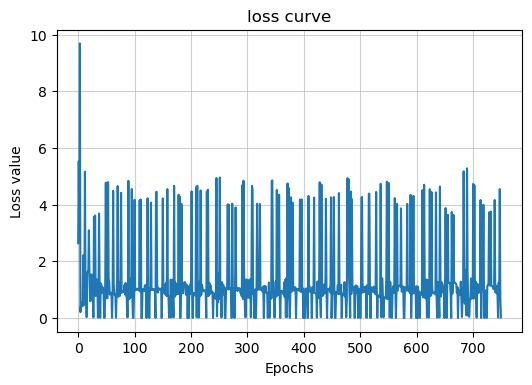

In [41]:
figure = plt.figure(figsize = (6,4), dpi=100)#绘制损失变化
plt.plot(np.arange(len(lossRecord)),lossRecord)
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('loss curve')
plt.grid(alpha=0.6)
plt.show()

## 测试模型
* 我们将验证集的数据输入模型进行验证

In [42]:
Model.eval()#测试模型
for i in range(len(val_data)):
    out=Model(val_data[i][0])
    print('predict:',out,'real:',val_data[i][1])

predict: tensor(1.6599, grad_fn=<SelectBackward>) real: tensor(4.)
predict: tensor(0.8660, grad_fn=<SelectBackward>) real: tensor(3.)
predict: tensor(0.1858, grad_fn=<SelectBackward>) real: tensor(2.)
predict: tensor(1.0183, grad_fn=<SelectBackward>) real: tensor(2.)


## 保存模型
* 将模型保存在目录下

In [43]:
torch.save(Model,'Model.pt')# 保存模型